# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/ResNet50V2_Per_Band/224_band3.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T = 0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

### Train Test split

In [5]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)
The train shape is: (130, 2049)
The test shape is: (33, 2049)


### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities)
test_df = pd.concat(test_df, keys=Municipalities)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1         2         3         4    5    6    7    8  \
41001 201546 -1.0 -1.0 -0.964952 -0.316784 -0.788104 -1.0 -1.0 -1.0 -1.0   
      201547 -1.0 -1.0 -0.964952 -0.316784 -0.788104 -1.0 -1.0 -1.0 -1.0   
      201548 -1.0 -1.0 -0.964952 -0.316784 -0.788104 -1.0 -1.0 -1.0 -1.0   
      201549 -1.0 -1.0 -0.964952 -0.316784 -0.788104 -1.0 -1.0 -1.0 -1.0   
      201550 -1.0 -1.0 -0.964952 -0.316784 -0.788104 -1.0 -1.0 -1.0 -1.0   

                    9  ...  2039      2040      2041  2042  2043      2044  \
41001 201546 -0.89722  ...  -1.0 -0.873244 -0.886071  -1.0  -1.0 -0.578939   
      201547 -0.89722  ...  -1.0 -0.873244 -0.886071  -1.0  -1.0 -0.578939   
      201548 -0.89722  ...  -1.0 -0.873244 -0.886071  -1.0  -1.0 -0.578939   
      201549 -0.89722  ...  -1.0 -0.873244 -0.886071  -1.0  -1.0 -0.578939   
      201550 -0.89722  ...  -1.0 -0.873244 -0.886071  -1.0  -1.0 -0.578939   

              2045      2046  2047    Labels  
41001 201546  -1.0 -0.914666  -1.0 -0.861740  
      201547  -1.0 -0.914666  -1.0 -0.854589  
      201548  -1.0 -0.914666  -1.0 -0.856973  
      201549  -1.0 -0.914666  -1.0 -0.856973  
      201550  -1.0 -0.914666  -1.0 -0.823600  

[5 rows x 2049 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities]

test_df[1].head()

0         1         2         3    4    5         6  \
41001 201820 -1.000000 -1.000000 -0.642076 -1.000000 -1.0 -1.0 -0.649935   
      201821 -1.000000 -0.983648 -1.000000 -0.954315 -1.0 -1.0 -0.959111   
      201822 -0.993085 -0.970962 -0.957245 -1.000000 -1.0 -1.0 -0.751133   
      201823 -1.000000 -0.830264 -0.803951 -1.000000 -1.0 -1.0 -1.000000   
      201824 -1.000000 -1.000000 -1.000000 -1.000000 -1.0 -1.0 -0.909459   

                     7         8         9  ...    2039      2040  2041  2042  \
41001 201820 -1.000000 -1.000000 -0.770250  ... -1.0000 -0.319731  -1.0  -1.0   
      201821  1.813409 -0.992489 -0.219437  ... -0.9611 -0.061751  -1.0  -1.0   
      201822  0.400741 -0.934840 -0.963722  ... -1.0000 -0.639639  -1.0  -1.0   
      201823 -1.000000 -0.958819 -0.778479  ... -1.0000 -0.998412  -1.0  -1.0   
      201824 -1.000000 -0.959629 -1.000000  ... -1.0000 -0.453674  -1.0  -1.0   

                  2043      2044      2045      2046      2047    Labels  
41001 201820 -0.937582 -1.000000 -1.000000 -1.000000 -1.000000 -0.949940  
      201821 -0.878020 -1.000000 -1.000000 -0.513811 -0.719359 -0.961859  
      201822 -0.963991 -0.946009 -1.000000 -0.704357 -0.879445 -0.940405  
      201823 -1.000000 -1.000000 -0.979911 -0.981275 -1.000000 -0.961859  
      201824 -0.987716 -1.000000 -1.000000 -0.896695 -1.000000 -0.954708  

[5 rows x 2049 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(130, 2049)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities)
test = pd.concat(test, keys=Municipalities)

In [11]:
train.shape

(1300, 2049)

### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1300, 2048)
The shape of the labels is (1300, 1)
Test:
The shape of the features is (330, 2048)
The shape of the labels is (330, 1)


In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

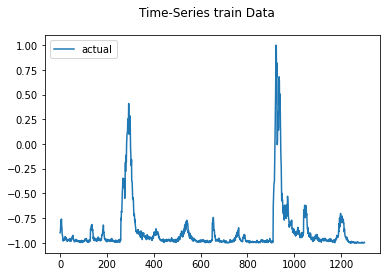

2023-03-07 13:09:57.715634: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-07 13:09:57.715760: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-07 13:09:57.715796: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9e0b1a08816a): /proc/driver/nvidia/version does not exist
2023-03-07 13:09:57.716568: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 13:09:58.182650: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Test MAE: 56.758
Test RMSE: 71.992
Test sMAPE: 102.354
Test R Squared: -4.363
{'mae': 56.758407985802855, 'rmse': 71.99166731929039, 'smape': 102.35403746526876, 'r2': -4.362983557512122}


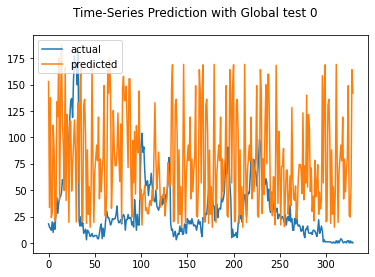

Test MAE: 54.787
Test RMSE: 70.889
Test sMAPE: 107.079
Test R Squared: -4.200
{'mae': 54.78710497491287, 'rmse': 70.88889226488345, 'smape': 107.07947552541609, 'r2': -4.199940587618715}


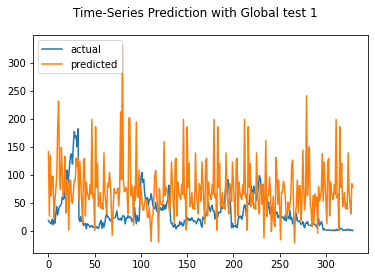

Test MAE: 47.858
Test RMSE: 57.691
Test sMAPE: 101.929
Test R Squared: -2.444
{'mae': 47.857670200954786, 'rmse': 57.69094077177943, 'smape': 101.92947866067138, 'r2': -2.4439532212646933}


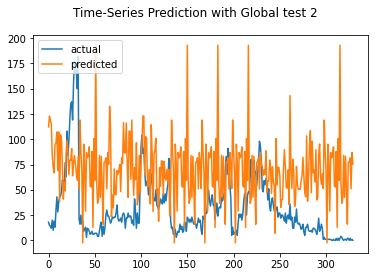

Test MAE: 44.733
Test RMSE: 62.702
Test sMAPE: 111.583
Test R Squared: -3.068
{'mae': 44.73325543466842, 'rmse': 62.702380890947396, 'smape': 111.58336790275155, 'r2': -3.068272784548424}


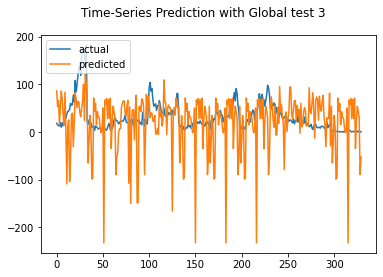

Test MAE: 49.421
Test RMSE: 62.879
Test sMAPE: 129.338
Test R Squared: -3.091
{'mae': 49.42088697968107, 'rmse': 62.87946780984414, 'smape': 129.33827645109915, 'r2': -3.091284837014201}


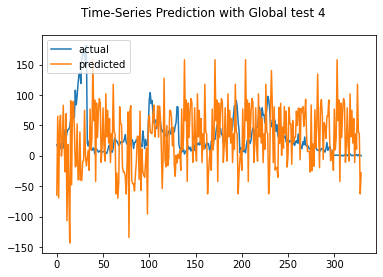

Test MAE: 110.960
Test RMSE: 131.319
Test sMAPE: 137.994
Test R Squared: -16.844
{'mae': 110.96040441050674, 'rmse': 131.31861323355278, 'smape': 137.99431919015197, 'r2': -16.844097076509925}


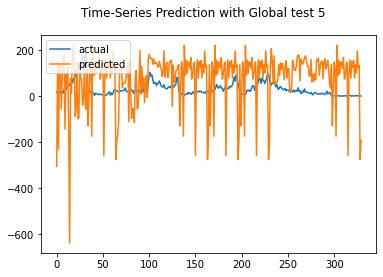

Test MAE: 75.526
Test RMSE: 93.488
Test sMAPE: 126.330
Test R Squared: -8.044
{'mae': 75.52647113763925, 'rmse': 93.48763480294859, 'smape': 126.32976858724005, 'r2': -8.04378744397396}


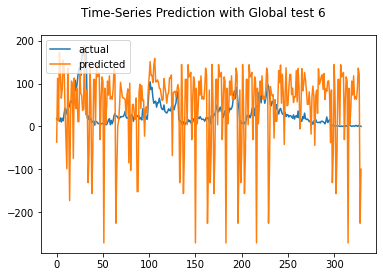

Test MAE: 54.594
Test RMSE: 90.015
Test sMAPE: 119.765
Test R Squared: -7.384
{'mae': 54.59432332931143, 'rmse': 90.01483579770027, 'smape': 119.76472892330311, 'r2': -7.384365241025737}


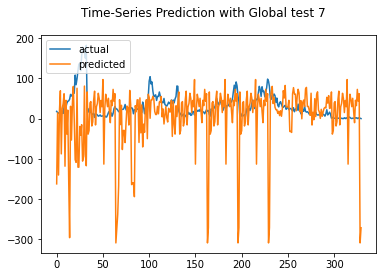

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 35.306
Test RMSE: 46.402
Test sMAPE: 129.298
Test R Squared: -1.228
{'mae': 35.30592424788258, 'rmse': 46.4015344635459, 'smape': 129.29783526418746, 'r2': -1.2279563957382371}


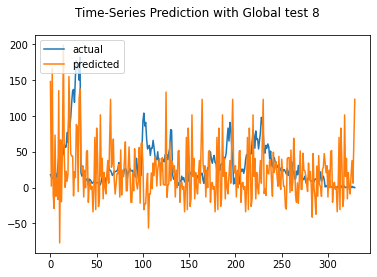

Test MAE: 68.652
Test RMSE: 79.293
Test sMAPE: 114.057
Test R Squared: -5.506
{'mae': 68.65240036935518, 'rmse': 79.29297138224916, 'smape': 114.05726353309453, 'r2': -5.505959972919653}


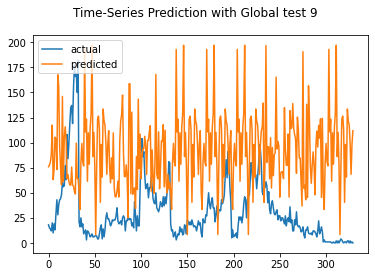

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 40.375
Test RMSE: 50.364
Test sMAPE: 99.085
Test R Squared: -1.625
{'mae': 40.37477154767875, 'rmse': 50.36410789188293, 'smape': 99.08543402025114, 'r2': -1.6247279315759253}


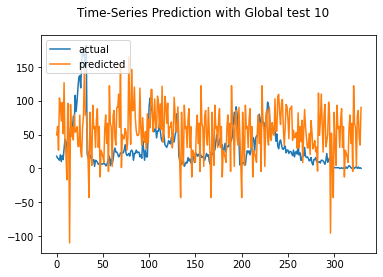

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 45.593
Test RMSE: 55.746
Test sMAPE: 103.005
Test R Squared: -2.216
{'mae': 45.5929998253331, 'rmse': 55.74635965068351, 'smape': 103.00487944460103, 'r2': -2.215696303044937}


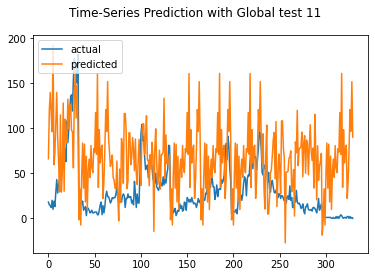

Test MAE: 52.635
Test RMSE: 69.112
Test sMAPE: 102.758
Test R Squared: -3.943
{'mae': 52.63469416733944, 'rmse': 69.112463620684, 'smape': 102.75791616839435, 'r2': -3.942591868624824}


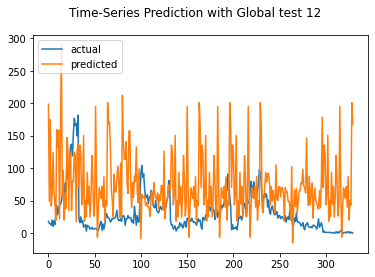

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 53.830
Test RMSE: 67.596
Test sMAPE: 128.537
Test R Squared: -3.728
{'mae': 53.830376810196675, 'rmse': 67.59566667974869, 'smape': 128.53700925376063, 'r2': -3.7280244435542773}


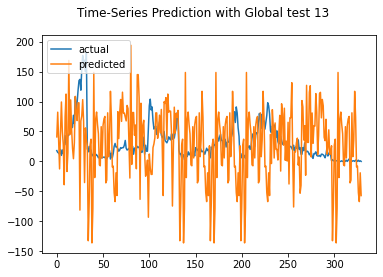

Test MAE: 41.153
Test RMSE: 55.736
Test sMAPE: 101.231
Test R Squared: -2.215
{'mae': 41.153421157779114, 'rmse': 55.73645079797389, 'smape': 101.23078894477402, 'r2': -2.2145532318437797}


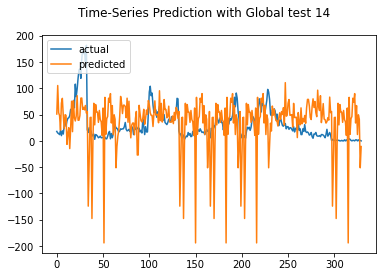

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 39.705
Test RMSE: 56.605
Test sMAPE: 96.801
Test R Squared: -2.316
{'mae': 39.70474133428299, 'rmse': 56.605355737914785, 'smape': 96.80142863976582, 'r2': -2.315561208432858}


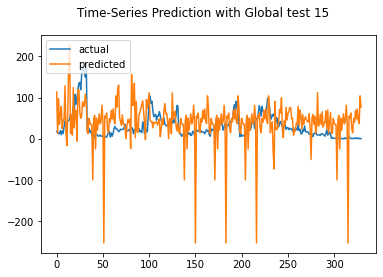

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 65.733
Test RMSE: 80.686
Test sMAPE: 118.563
Test R Squared: -5.737
{'mae': 65.73280062747725, 'rmse': 80.6858355991495, 'smape': 118.56288289829732, 'r2': -5.736535514194208}


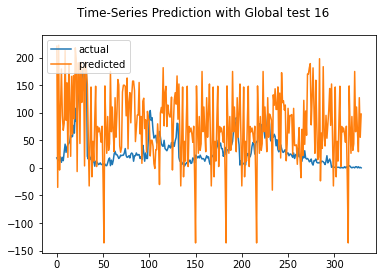

Test MAE: 46.992
Test RMSE: 56.757
Test sMAPE: 99.953
Test R Squared: -2.333
{'mae': 46.99201396595348, 'rmse': 56.756821468728894, 'smape': 99.95277240313445, 'r2': -2.33332863644837}


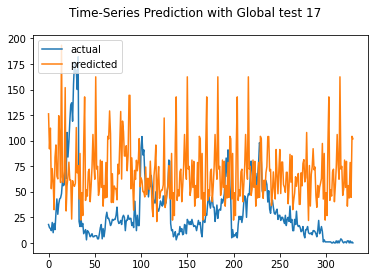

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 49.412
Test RMSE: 60.992
Test sMAPE: 145.909
Test R Squared: -2.849
{'mae': 49.41200343442686, 'rmse': 60.992101750068414, 'smape': 145.9087018358533, 'r2': -2.8493659459205336}


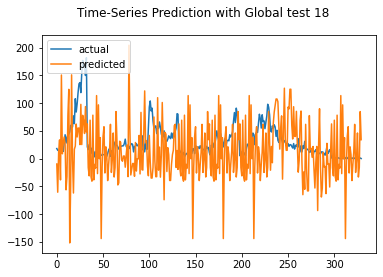

Test MAE: 69.820
Test RMSE: 99.649
Test sMAPE: 123.732
Test R Squared: -9.275
{'mae': 69.82016849824876, 'rmse': 99.64923731515213, 'smape': 123.73199278064126, 'r2': -9.275192333399714}


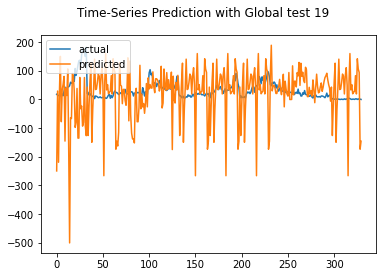

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 31.573
Test RMSE: 41.343
Test sMAPE: 97.443
Test R Squared: -0.769
{'mae': 31.57318139166543, 'rmse': 41.34260146065193, 'smape': 97.44324188728918, 'r2': -0.7686325089641928}


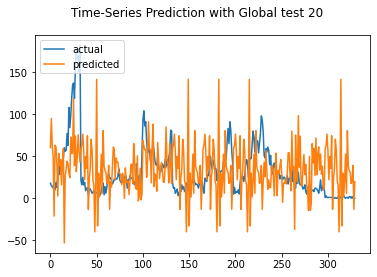

Test MAE: 73.688
Test RMSE: 93.819
Test sMAPE: 134.499
Test R Squared: -8.108
{'mae': 73.6876972913742, 'rmse': 93.8186737586299, 'smape': 134.49908874707316, 'r2': -8.107948796419743}


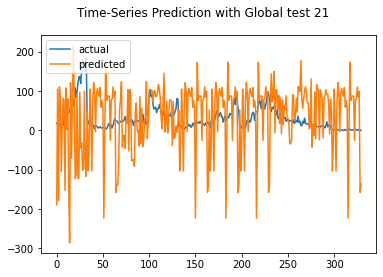

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 53.071
Test RMSE: 72.736
Test sMAPE: 125.493
Test R Squared: -4.474
{'mae': 53.07097891894254, 'rmse': 72.73595866545344, 'smape': 125.49337710098153, 'r2': -4.474448015733301}


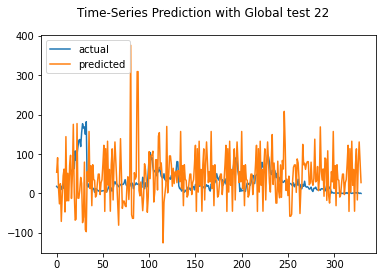

Test MAE: 47.666
Test RMSE: 55.422
Test sMAPE: 103.676
Test R Squared: -2.178
{'mae': 47.666268133394645, 'rmse': 55.42228205913277, 'smape': 103.67615937984154, 'r2': -2.178416526230927}


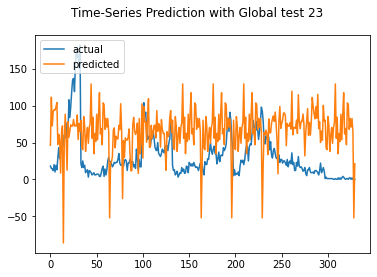

Test MAE: 70.729
Test RMSE: 82.926
Test sMAPE: 115.257
Test R Squared: -6.116
{'mae': 70.72872401439783, 'rmse': 82.9261566156154, 'smape': 115.25732124542503, 'r2': -6.115822016337034}


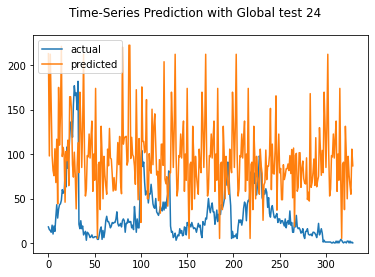

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 43.091
Test RMSE: 56.709
Test sMAPE: 122.031
Test R Squared: -2.328
{'mae': 43.091040500366326, 'rmse': 56.7085057693085, 'smape': 122.03126496023064, 'r2': -2.3276558890874126}


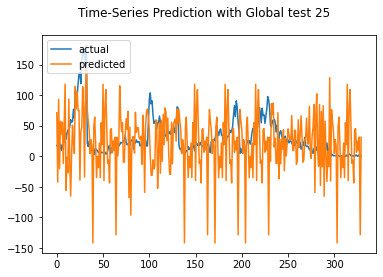

Test MAE: 32.065
Test RMSE: 43.567
Test sMAPE: 95.934
Test R Squared: -0.964
{'mae': 32.06475134645448, 'rmse': 43.56654970417448, 'smape': 95.93401584249234, 'r2': -0.9640309871115482}


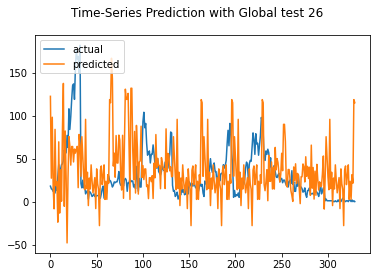

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 39.112
Test RMSE: 50.186
Test sMAPE: 104.266
Test R Squared: -1.606
{'mae': 39.11151126939239, 'rmse': 50.18628404937551, 'smape': 104.26634260842215, 'r2': -1.6062260558337034}


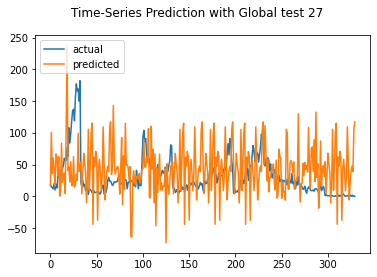

Test MAE: 88.530
Test RMSE: 122.864
Test sMAPE: 136.487
Test R Squared: -14.620
{'mae': 88.53046892592401, 'rmse': 122.86372511554714, 'smape': 136.48676927442375, 'r2': -14.620299578008167}


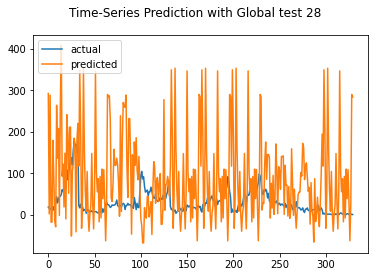

Test MAE: 48.688
Test RMSE: 60.766
Test sMAPE: 132.435
Test R Squared: -2.821
{'mae': 48.687506490042715, 'rmse': 60.76624605701932, 'smape': 132.43488565431673, 'r2': -2.8209100810317973}


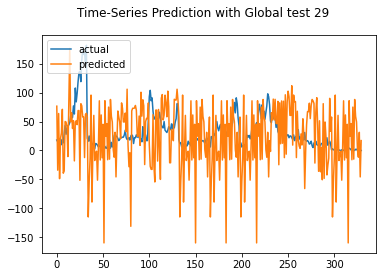

Test MAE: 50.176
Test RMSE: 62.888
Test sMAPE: 116.293
Test R Squared: -3.092
{'mae': 50.175945330388615, 'rmse': 62.888161032811986, 'smape': 116.29297416322119, 'r2': -3.092416173239574}


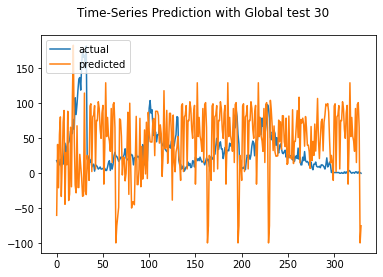

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 41.199
Test RMSE: 58.868
Test sMAPE: 120.517
Test R Squared: -2.586
{'mae': 41.19893039410765, 'rmse': 58.86770556804726, 'smape': 120.5173555709023, 'r2': -2.585883862354298}


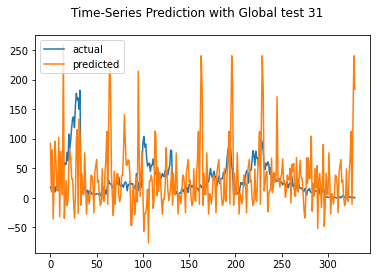

Test MAE: 38.392
Test RMSE: 52.429
Test sMAPE: 133.179
Test R Squared: -1.844
{'mae': 38.39173381734978, 'rmse': 52.429252339164485, 'smape': 133.17874598895273, 'r2': -1.8443912290022557}


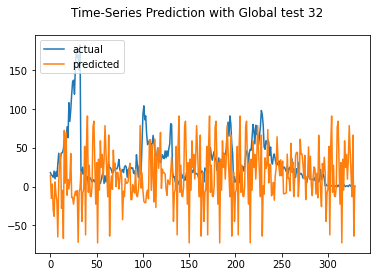

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 48.292
Test RMSE: 57.250
Test sMAPE: 112.767
Test R Squared: -2.392
{'mae': 48.291663992043695, 'rmse': 57.24992941237933, 'smape': 112.76739683075841, 'r2': -2.3915007132991257}


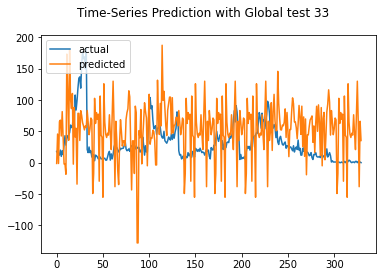

Test MAE: 92.628
Test RMSE: 141.243
Test sMAPE: 115.906
Test R Squared: -19.643
{'mae': 92.6278789802031, 'rmse': 141.2433332667312, 'smape': 115.9058609842474, 'r2': -19.643242670484902}


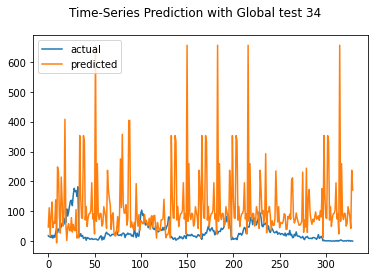

Test MAE: 83.571
Test RMSE: 96.311
Test sMAPE: 123.086
Test R Squared: -8.598
{'mae': 83.5712376796838, 'rmse': 96.31097694234842, 'smape': 123.08563890006765, 'r2': -8.598283604551716}


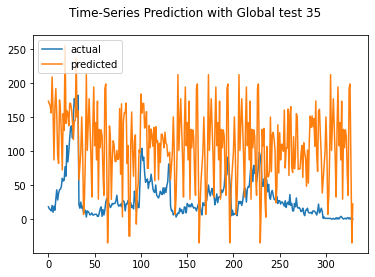

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 54.397
Test RMSE: 64.538
Test sMAPE: 107.761
Test R Squared: -3.310
{'mae': 54.396690199953134, 'rmse': 64.53809384125897, 'smape': 107.76050537383527, 'r2': -3.309970226596068}


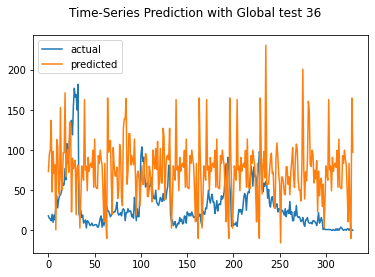

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 55.597
Test RMSE: 70.911
Test sMAPE: 118.049
Test R Squared: -4.203
{'mae': 55.59690794691895, 'rmse': 70.91082498572369, 'smape': 118.04946921028618, 'r2': -4.203158764254371}


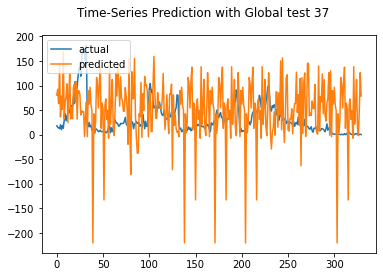

Test MAE: 53.818
Test RMSE: 68.025
Test sMAPE: 110.892
Test R Squared: -3.788
{'mae': 53.81828197457573, 'rmse': 68.02475274043532, 'smape': 110.8924832522582, 'r2': -3.7882403864334924}


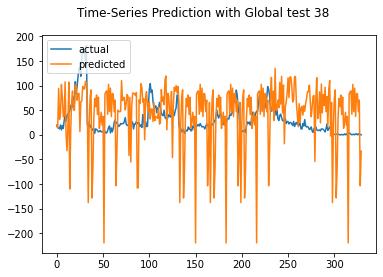

Test MAE: 86.120
Test RMSE: 131.516
Test sMAPE: 131.341
Test R Squared: -16.898
{'mae': 86.11997292800383, 'rmse': 131.51596261749918, 'smape': 131.34088979900406, 'r2': -16.897770620575468}


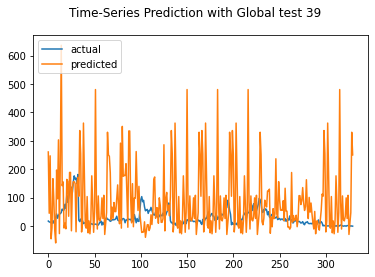

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 35.306
Test RMSE: 48.037
Test sMAPE: 106.803
Test R Squared: -1.388
{'mae': 35.305710811145374, 'rmse': 48.03678027903078, 'smape': 106.8026662777003, 'r2': -1.3877551085027156}


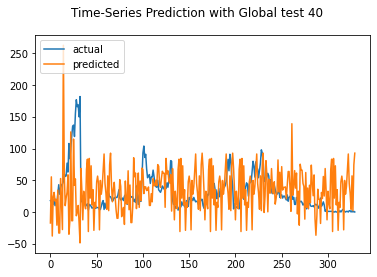

Test MAE: 102.793
Test RMSE: 127.887
Test sMAPE: 133.956
Test R Squared: -15.924
{'mae': 102.79268476999167, 'rmse': 127.88665815036633, 'smape': 133.95585493894703, 'r2': -15.923589375206852}


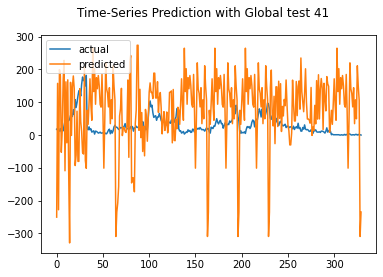

Test MAE: 56.282
Test RMSE: 64.074
Test sMAPE: 115.671
Test R Squared: -3.248
{'mae': 56.281616776278526, 'rmse': 64.07351530856275, 'smape': 115.67059312116228, 'r2': -3.2481427799021105}


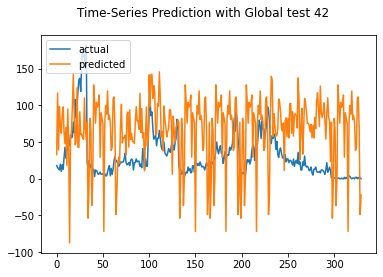

Test MAE: 58.305
Test RMSE: 73.260
Test sMAPE: 135.993
Test R Squared: -4.554
{'mae': 58.305111590569666, 'rmse': 73.26046509550508, 'smape': 135.9928449601924, 'r2': -4.553686295035082}


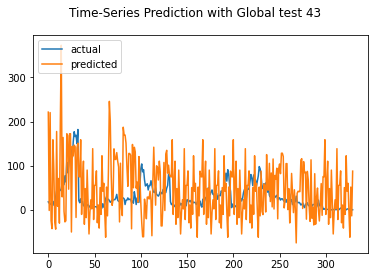

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 57.956
Test RMSE: 80.744
Test sMAPE: 127.537
Test R Squared: -5.746
{'mae': 57.95568889361439, 'rmse': 80.74421271720949, 'smape': 127.53707118149296, 'r2': -5.746286960404639}


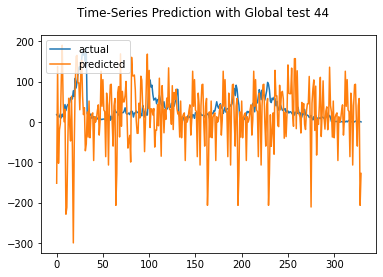

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 50.531
Test RMSE: 64.058
Test sMAPE: 103.427
Test R Squared: -3.246
{'mae': 50.530515214891146, 'rmse': 64.05823603556684, 'smape': 103.42686395860565, 'r2': -3.2461169571031094}


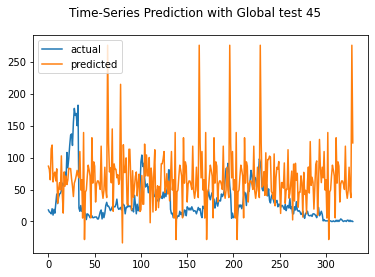

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 45.383
Test RMSE: 61.222
Test sMAPE: 110.851
Test R Squared: -2.878
{'mae': 45.38320094870799, 'rmse': 61.22227568403383, 'smape': 110.85098901560544, 'r2': -2.878474487183851}


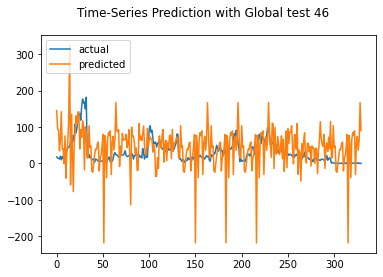

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 43.703
Test RMSE: 54.487
Test sMAPE: 107.493
Test R Squared: -2.072
{'mae': 43.703325287139776, 'rmse': 54.4868807794769, 'smape': 107.49335786903896, 'r2': -2.07203312743471}


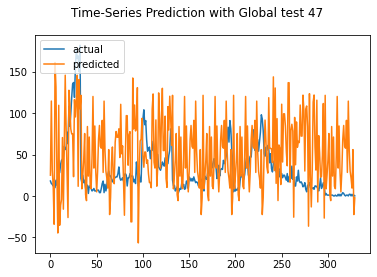

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 50.756
Test RMSE: 64.388
Test sMAPE: 114.211
Test R Squared: -3.290
{'mae': 50.7558661366954, 'rmse': 64.38796996188601, 'smape': 114.21067159092587, 'r2': -3.28994246081587}


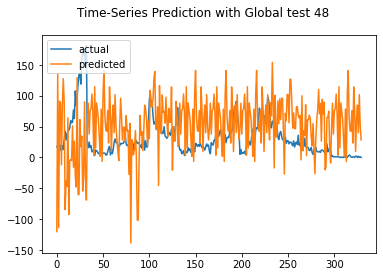

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 37.848
Test RMSE: 54.657
Test sMAPE: 107.413
Test R Squared: -2.091
{'mae': 37.84756524887952, 'rmse': 54.65730269851424, 'smape': 107.41315995564496, 'r2': -2.091280349154886}


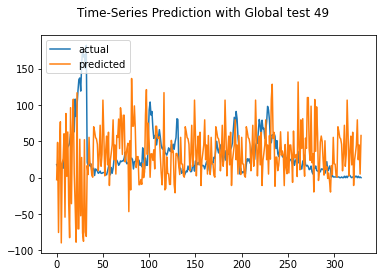

Test MAE: 36.264
Test RMSE: 48.234
Test sMAPE: 96.672
Test R Squared: -1.407
{'mae': 36.263817831332034, 'rmse': 48.23358042656931, 'smape': 96.67184215086058, 'r2': -1.4073598003528796}


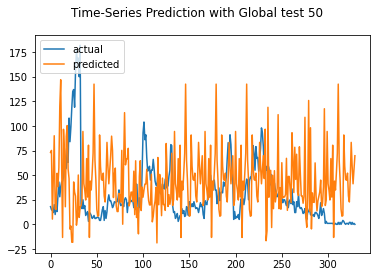

Test MAE: 39.424
Test RMSE: 45.559
Test sMAPE: 97.845
Test R Squared: -1.148
{'mae': 39.42445071104801, 'rmse': 45.55901277906367, 'smape': 97.84521223673049, 'r2': -1.1477840416197211}


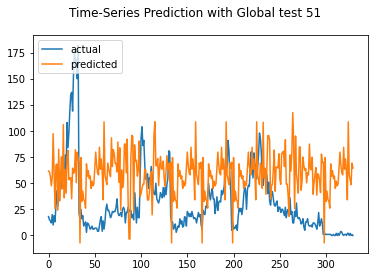

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 34.323
Test RMSE: 43.552
Test sMAPE: 110.060
Test R Squared: -0.963
{'mae': 34.322858184395415, 'rmse': 43.55187794058169, 'smape': 110.06046255041781, 'r2': -0.9627083693496803}


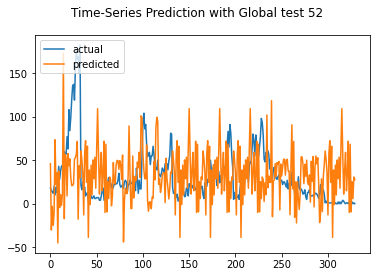

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 32.084
Test RMSE: 41.031
Test sMAPE: 96.371
Test R Squared: -0.742
{'mae': 32.0838228727832, 'rmse': 41.03066785479113, 'smape': 96.37074236047422, 'r2': -0.7420442150899189}


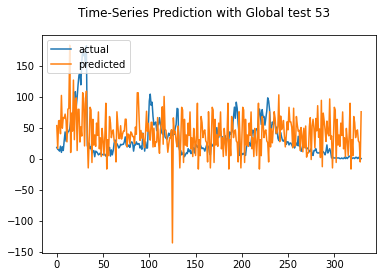

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 44.613
Test RMSE: 54.987
Test sMAPE: 101.354
Test R Squared: -2.129
{'mae': 44.61256288398396, 'rmse': 54.98657373165708, 'smape': 101.35435484052556, 'r2': -2.1286380301720738}


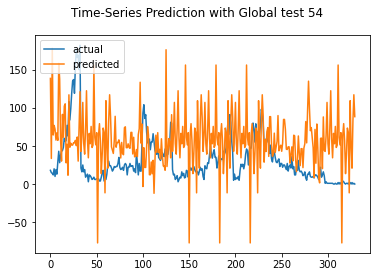

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 40.531
Test RMSE: 49.814
Test sMAPE: 99.031
Test R Squared: -1.568
{'mae': 40.53081928031011, 'rmse': 49.81399351092218, 'smape': 99.03114369666251, 'r2': -1.5677026029679455}


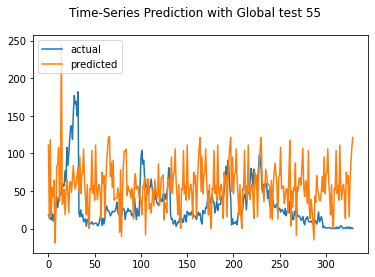

Test MAE: 101.934
Test RMSE: 132.252
Test sMAPE: 124.659
Test R Squared: -17.099
{'mae': 101.934361001217, 'rmse': 132.25153315245038, 'smape': 124.65856409271457, 'r2': -17.098535435139176}


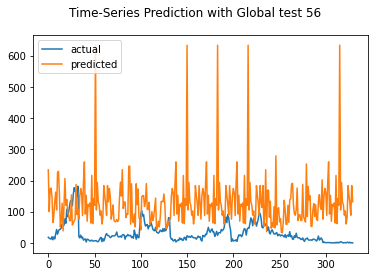

Test MAE: 58.269
Test RMSE: 68.787
Test sMAPE: 111.301
Test R Squared: -3.896
{'mae': 58.26942704446388, 'rmse': 68.78663040208126, 'smape': 111.30059013235226, 'r2': -3.896097669312468}


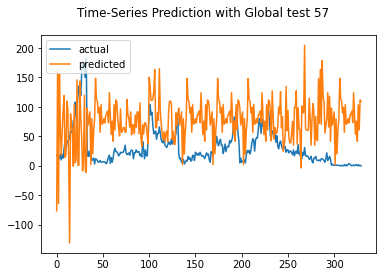

Test MAE: 62.075
Test RMSE: 75.473
Test sMAPE: 118.615
Test R Squared: -4.894
{'mae': 62.07475488366503, 'rmse': 75.47263700654615, 'smape': 118.61540881915253, 'r2': -4.8941481894153664}


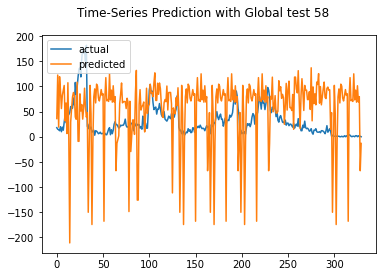

Test MAE: 66.370
Test RMSE: 104.758
Test sMAPE: 123.356
Test R Squared: -10.356
{'mae': 66.36970786994154, 'rmse': 104.75808319884943, 'smape': 123.35623870304867, 'r2': -10.355783091015539}


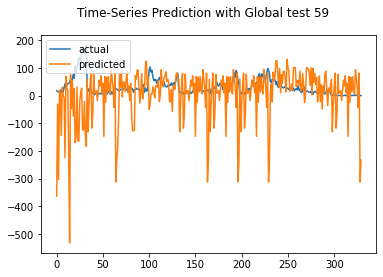

Test MAE: 55.408
Test RMSE: 63.501
Test sMAPE: 112.055
Test R Squared: -3.173
{'mae': 55.40775505376585, 'rmse': 63.500571082964676, 'smape': 112.05470870113173, 'r2': -3.1725088241255044}


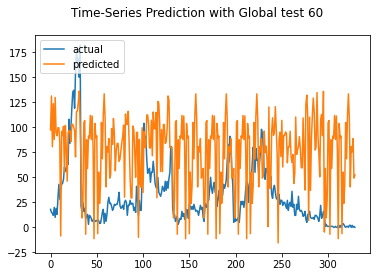

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 35.519
Test RMSE: 45.396
Test sMAPE: 112.405
Test R Squared: -1.132
{'mae': 35.51923979565953, 'rmse': 45.396137680122045, 'smape': 112.40502506518021, 'r2': -1.1324546827719306}


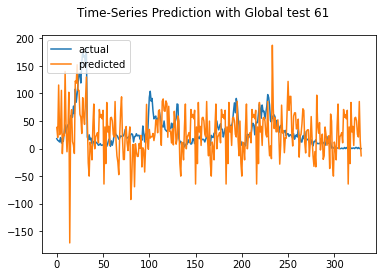

Test MAE: 93.342
Test RMSE: 109.510
Test sMAPE: 123.542
Test R Squared: -11.409
{'mae': 93.34239987604546, 'rmse': 109.50988703501771, 'smape': 123.54242374670943, 'r2': -11.40933942159596}


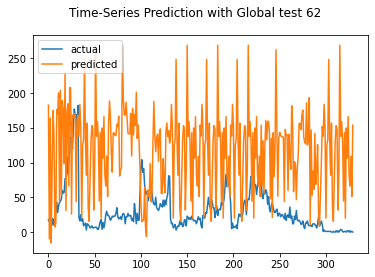

Test MAE: 62.553
Test RMSE: 73.117
Test sMAPE: 111.388
Test R Squared: -4.532
{'mae': 62.55330919207949, 'rmse': 73.11653518391371, 'smape': 111.38763851415902, 'r2': -4.531885822704617}


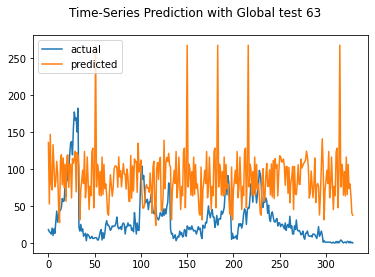

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 51.677
Test RMSE: 62.711
Test sMAPE: 110.799
Test R Squared: -3.069
{'mae': 51.676903867721556, 'rmse': 62.710533915640575, 'smape': 110.798735212372, 'r2': -3.069330826824353}


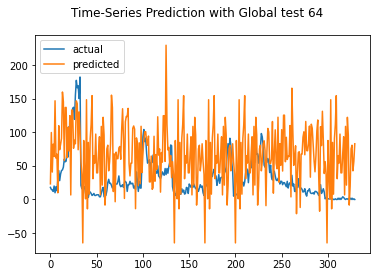

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 41.226
Test RMSE: 52.563
Test sMAPE: 103.403
Test R Squared: -1.859
{'mae': 41.22589539190133, 'rmse': 52.563449709053714, 'smape': 103.40342620739949, 'r2': -1.8589708125387117}


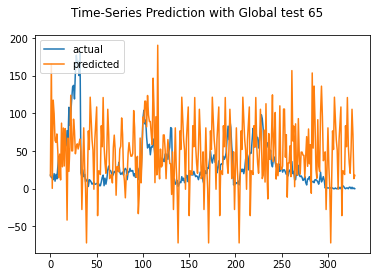

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 48.450
Test RMSE: 64.170
Test sMAPE: 120.038
Test R Squared: -3.261
{'mae': 48.449688497817874, 'rmse': 64.16966390841803, 'smape': 120.03835723999289, 'r2': -3.260901856416077}


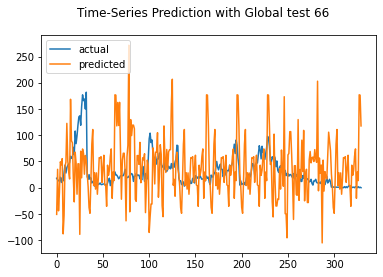

Test MAE: 50.827
Test RMSE: 63.886
Test sMAPE: 111.758
Test R Squared: -3.223
{'mae': 50.826952311848146, 'rmse': 63.88635745038464, 'smape': 111.75815578563386, 'r2': -3.2233614923140097}


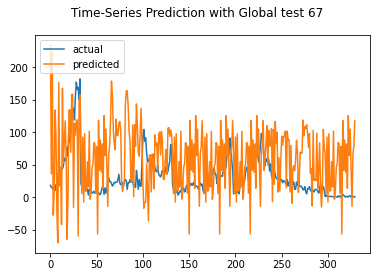

Test MAE: 85.484
Test RMSE: 133.550
Test sMAPE: 128.246
Test R Squared: -17.456
{'mae': 85.48408037117034, 'rmse': 133.55015696785503, 'smape': 128.24641031579333, 'r2': -17.455712120695612}


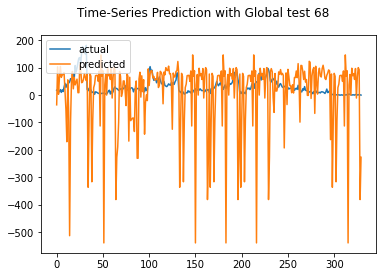

Test MAE: 156.563
Test RMSE: 277.765
Test sMAPE: 127.264
Test R Squared: -78.836
{'mae': 156.56335996190708, 'rmse': 277.76504601255624, 'smape': 127.26409783888997, 'r2': -78.83570927625712}


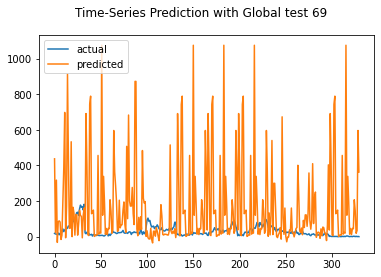

Test MAE: 69.493
Test RMSE: 91.294
Test sMAPE: 108.870
Test R Squared: -7.624
{'mae': 69.49307757327051, 'rmse': 91.29419316105897, 'smape': 108.86993049557127, 'r2': -7.624388488107149}


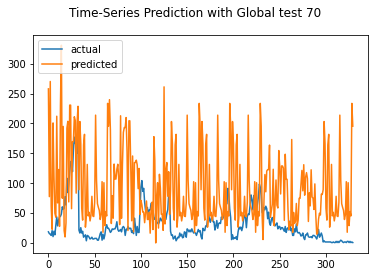

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 40.708
Test RMSE: 52.429
Test sMAPE: 99.797
Test R Squared: -1.844
{'mae': 40.70788685589125, 'rmse': 52.42897792602866, 'smape': 99.7965475002975, 'r2': -1.8443614541632427}


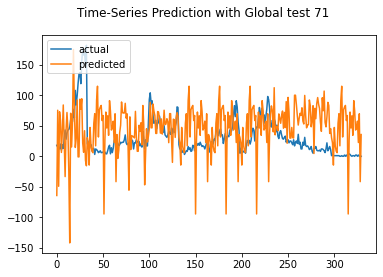

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 38.547
Test RMSE: 48.555
Test sMAPE: 104.356
Test R Squared: -1.440
{'mae': 38.5472258872155, 'rmse': 48.55460253064864, 'smape': 104.35633412244029, 'r2': -1.4395111549534332}


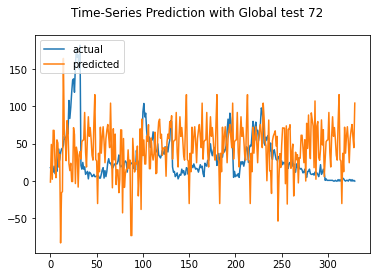

Test MAE: 67.937
Test RMSE: 83.663
Test sMAPE: 119.388
Test R Squared: -6.243
{'mae': 67.93735825870976, 'rmse': 83.66254982276635, 'smape': 119.38808849134873, 'r2': -6.24276167649198}


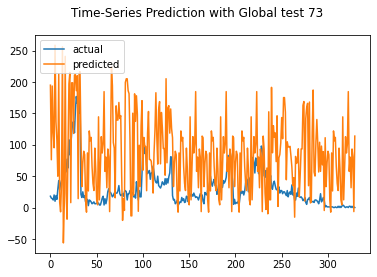

Test MAE: 56.705
Test RMSE: 75.307
Test sMAPE: 105.592
Test R Squared: -4.868
{'mae': 56.70461775750825, 'rmse': 75.3068649469415, 'smape': 105.59182406616122, 'r2': -4.868284192522878}


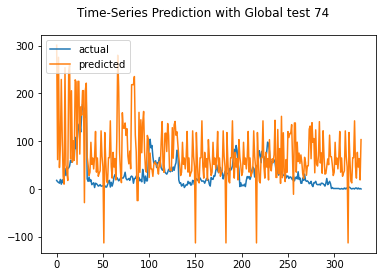

Test MAE: 58.910
Test RMSE: 83.840
Test sMAPE: 118.146
Test R Squared: -6.274
{'mae': 58.910343913779116, 'rmse': 83.84011314354812, 'smape': 118.14563995468237, 'r2': -6.273538016842364}


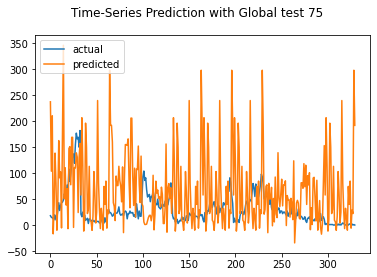

Test MAE: 55.681
Test RMSE: 69.956
Test sMAPE: 132.823
Test R Squared: -4.064
{'mae': 55.68112271410046, 'rmse': 69.95555466366712, 'smape': 132.82259252995973, 'r2': -4.0639150368847705}


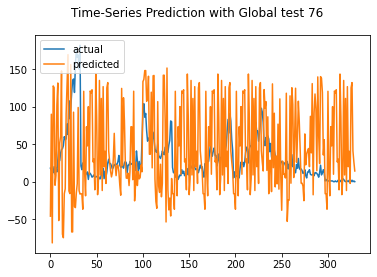

Restoring model weights from the end of the best epoch.
Epoch 00042: early stopping
Test MAE: 42.412
Test RMSE: 54.109
Test sMAPE: 114.079
Test R Squared: -2.030
{'mae': 42.41168703238169, 'rmse': 54.1091481024634, 'smape': 114.07888609281072, 'r2': -2.0295867626047706}


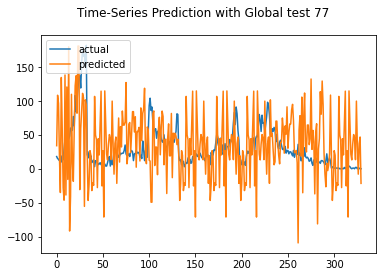

Test MAE: 39.259
Test RMSE: 49.050
Test sMAPE: 96.551
Test R Squared: -1.490
{'mae': 39.25860418550896, 'rmse': 49.04997576016814, 'smape': 96.55061447604368, 'r2': -1.4895427932535918}


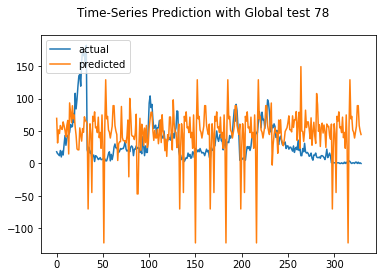

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 51.008
Test RMSE: 65.724
Test sMAPE: 109.461
Test R Squared: -3.470
{'mae': 51.00815608934923, 'rmse': 65.72418087668912, 'smape': 109.46057171403176, 'r2': -3.469843997374271}


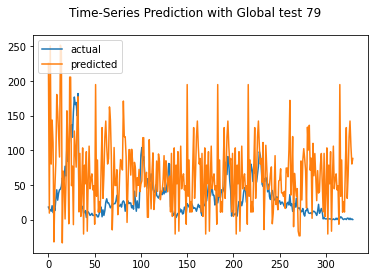

Test MAE: 51.303
Test RMSE: 72.786
Test sMAPE: 129.985
Test R Squared: -4.482
{'mae': 51.30296973242904, 'rmse': 72.78587310063455, 'smape': 129.98509857277872, 'r2': -4.4819641809083555}


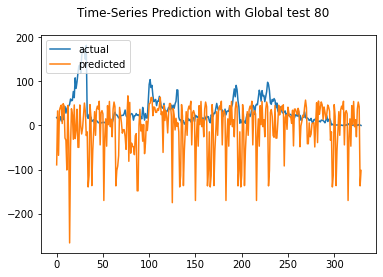

Test MAE: 57.189
Test RMSE: 76.724
Test sMAPE: 131.583
Test R Squared: -5.091
{'mae': 57.18870433966319, 'rmse': 76.72353630146817, 'smape': 131.58309070991135, 'r2': -5.091149031437353}


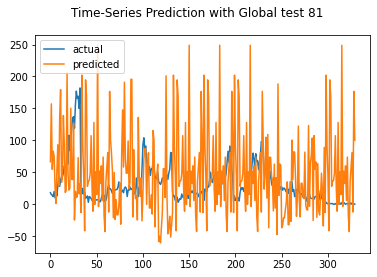

Test MAE: 32.064
Test RMSE: 44.070
Test sMAPE: 107.956
Test R Squared: -1.010
{'mae': 32.06373521450794, 'rmse': 44.069956541317296, 'smape': 107.95566002056832, 'r2': -1.009681553147188}


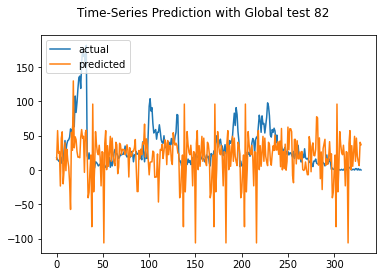

Test MAE: 116.051
Test RMSE: 185.028
Test sMAPE: 129.904
Test R Squared: -34.426
{'mae': 116.0511783442714, 'rmse': 185.02816781288473, 'smape': 129.904188955335, 'r2': -34.425639465819394}


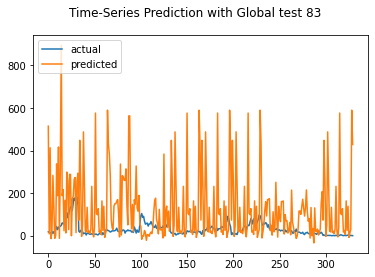

Test MAE: 79.422
Test RMSE: 101.568
Test sMAPE: 125.577
Test R Squared: -9.675
{'mae': 79.42197481213194, 'rmse': 101.56810935803396, 'smape': 125.57667596125015, 'r2': -9.674726049784123}


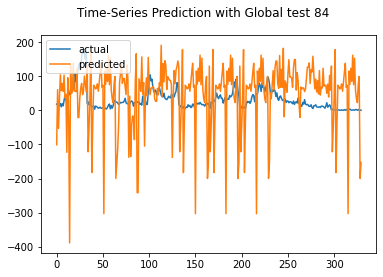

Test MAE: 49.532
Test RMSE: 62.034
Test sMAPE: 101.799
Test R Squared: -2.982
{'mae': 49.53175944703998, 'rmse': 62.03406640737014, 'smape': 101.7989378909513, 'r2': -2.982011435606618}


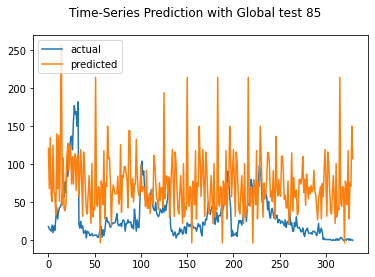

Test MAE: 56.868
Test RMSE: 71.120
Test sMAPE: 115.237
Test R Squared: -4.234
{'mae': 56.86806591406013, 'rmse': 71.11956489858599, 'smape': 115.23722526629697, 'r2': -4.233836886855956}


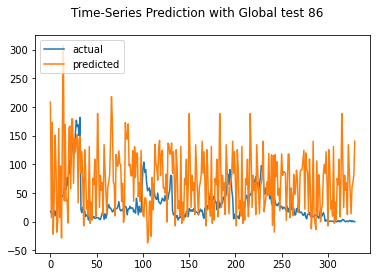

Test MAE: 57.901
Test RMSE: 77.849
Test sMAPE: 122.988
Test R Squared: -5.271
{'mae': 57.900880489024246, 'rmse': 77.84877128481199, 'smape': 122.9875228270241, 'r2': -5.271125993981349}


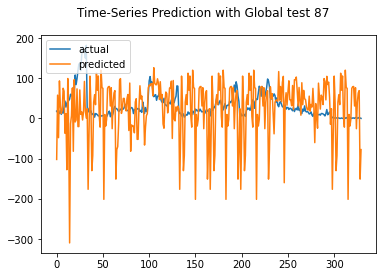

Test MAE: 88.821
Test RMSE: 136.541
Test sMAPE: 138.935
Test R Squared: -18.291
{'mae': 88.82069623813484, 'rmse': 136.54051241906626, 'smape': 138.93514981887742, 'r2': -18.291458294634403}


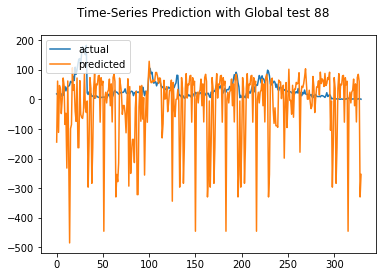

Test MAE: 50.770
Test RMSE: 69.434
Test sMAPE: 108.422
Test R Squared: -3.989
{'mae': 50.76976026368864, 'rmse': 69.4335279217409, 'smape': 108.42204103573698, 'r2': -3.9886204919922372}


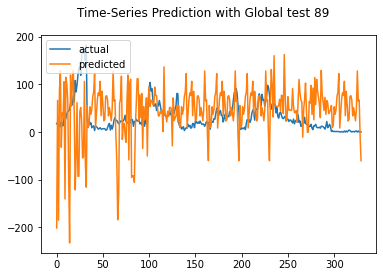

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 44.109
Test RMSE: 61.172
Test sMAPE: 107.298
Test R Squared: -2.872
{'mae': 44.108659051584475, 'rmse': 61.172393527702894, 'smape': 107.29818391869236, 'r2': -2.8721569221151193}


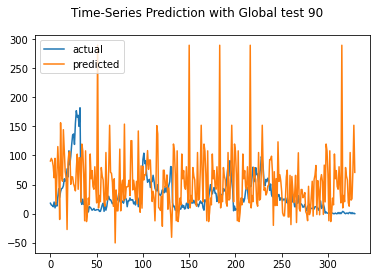

Test MAE: 41.541
Test RMSE: 52.862
Test sMAPE: 102.249
Test R Squared: -1.892
{'mae': 41.541046414230806, 'rmse': 52.86205091396837, 'smape': 102.24853267849544, 'r2': -1.8915454228898962}


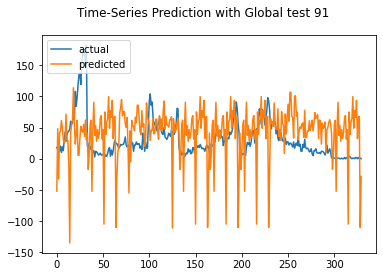

Test MAE: 67.828
Test RMSE: 91.803
Test sMAPE: 107.435
Test R Squared: -7.721
{'mae': 67.82767262603298, 'rmse': 91.80283586189964, 'smape': 107.43518443517814, 'r2': -7.7207572136781035}


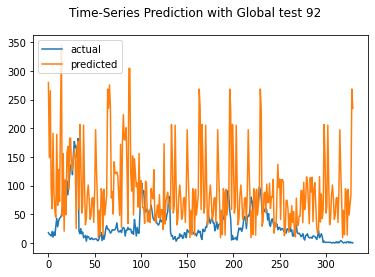

Test MAE: 53.339
Test RMSE: 64.305
Test sMAPE: 104.370
Test R Squared: -3.279
{'mae': 53.33915594852332, 'rmse': 64.30531146165272, 'smape': 104.36998272000166, 'r2': -3.2789350443722043}


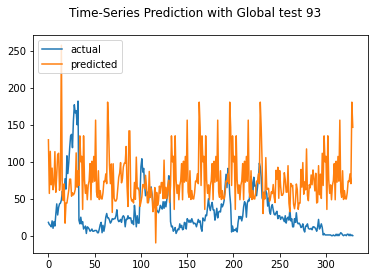

Test MAE: 32.408
Test RMSE: 43.306
Test sMAPE: 101.348
Test R Squared: -0.941
{'mae': 32.40762800502055, 'rmse': 43.3063158078076, 'smape': 101.34833935111698, 'r2': -0.9406377666910777}


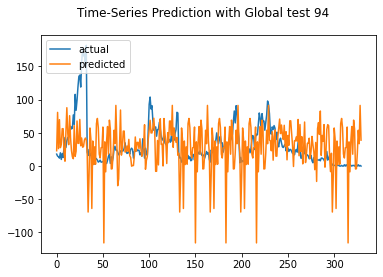

Test MAE: 113.888
Test RMSE: 158.305
Test sMAPE: 138.539
Test R Squared: -24.932
{'mae': 113.88794118563334, 'rmse': 158.30478934374386, 'smape': 138.53946006642224, 'r2': -24.93164753615219}


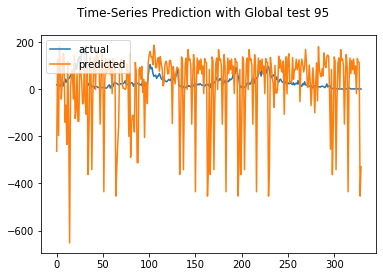

Test MAE: 68.381
Test RMSE: 106.288
Test sMAPE: 121.580
Test R Squared: -10.690
{'mae': 68.38103487292925, 'rmse': 106.28844574785613, 'smape': 121.57987585688589, 'r2': -10.6899893234325}


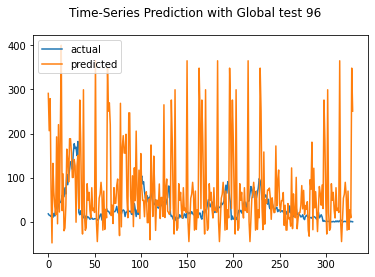

Test MAE: 48.904
Test RMSE: 65.623
Test sMAPE: 114.138
Test R Squared: -3.456
{'mae': 48.904477803996116, 'rmse': 65.62315418151374, 'smape': 114.13769795431833, 'r2': -3.456113084427022}


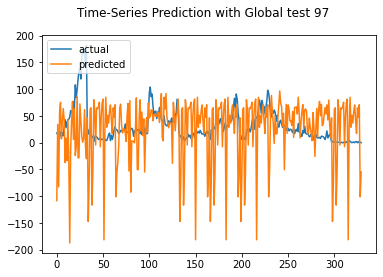

Test MAE: 63.770
Test RMSE: 87.579
Test sMAPE: 125.115
Test R Squared: -6.937
{'mae': 63.77000606746385, 'rmse': 87.57852522351506, 'smape': 125.115126523485, 'r2': -6.9366505159369645}


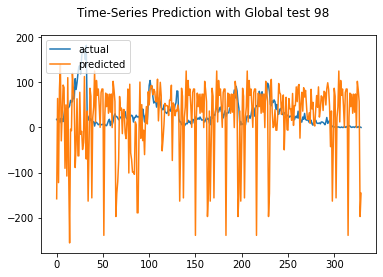

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 49.831
Test RMSE: 63.770
Test sMAPE: 121.223
Test R Squared: -3.208
{'mae': 49.83088506415035, 'rmse': 63.770099339698085, 'smape': 121.22260377112444, 'r2': -3.208004433459312}


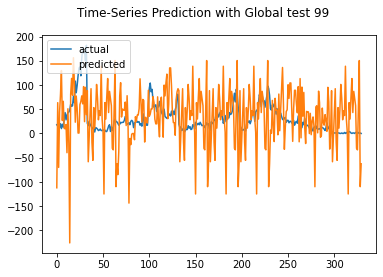

rmse : average=75.737, std=34.125
mae : average=57.166, std=21.233
smape : average=115.249, std=12.163
r2 : average=-6.141, std=9.178


([75.7374870929888, 34.1248824440212],
 [57.16621976627816, 21.23278962461546],
 [115.24875363524002, 12.163257591647264],
 [-6.140580959426566, 9.177841474569222])

In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]


calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')